In [710]:
import requests
from bs4 import BeautifulSoup

# import class for financial data
import yfinance as yf

# import class for data manipulation and analysis
import pandas as pd
import numpy as np

# import class for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#import class for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS


# import class for evaluation metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# import class for formalized statisitcial tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller, acf, pacf, coint
from statsmodels.tsa.arima.model import ARIMA

# import class for connection to broker 
from ib_insync import *
import nest_asyncio

# import class(s) for supportive functions
import datetime as dt
from scipy.stats import randint, uniform


In [711]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, 'html.parser')
data = soup.find('table')

df = pd.read_html(str(data))[0]
df.head()


/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/2269021368.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(data))[0]


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [712]:
df[df['GICS Sub-Industry'] == 'Semiconductors']

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
34,ADI,Analog Devices,Information Technology,Semiconductors,"Wilmington, Massachusetts",1999-10-12,6281,1965
71,AVGO,Broadcom,Information Technology,Semiconductors,"Palo Alto, California",2014-05-08,1730168,1961
195,FSLR,First Solar,Information Technology,Semiconductors,"Tempe, Arizona",2022-12-19,1274494,1999
249,INTC,Intel,Information Technology,Semiconductors,"Santa Clara, California",1976-12-31,50863,1968
315,MCHP,Microchip Technology,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054,1989
316,MU,Micron Technology,Information Technology,Semiconductors,"Boise, Idaho",1994-09-27,723125,1978
324,MPWR,Monolithic Power Systems,Information Technology,Semiconductors,"Kirkland, Washington",2021-02-12,1280452,1997
347,NVDA,Nvidia,Information Technology,Semiconductors,"Santa Clara, California",2001-11-30,1045810,1993
349,NXPI,NXP Semiconductors,Information Technology,Semiconductors,"Eindhoven, Netherlands",2021-03-22,1413447,1953


In [713]:
tickers_list = df[df['GICS Sub-Industry'] == 'Semiconductors']['Symbol'].tolist()
tickers_list

['AMD',
 'ADI',
 'AVGO',
 'FSLR',
 'INTC',
 'MCHP',
 'MU',
 'MPWR',
 'NVDA',
 'NXPI',
 'ON',
 'QCOM',
 'SWKS',
 'TXN']

In [714]:
current_date = dt.datetime.now().strftime('%Y-%m-%d')
df = yf.download(tickers_list, start = '2020-01-01', end = current_date)['Close']
df

[*********************100%***********************]  14 of 14 completed


Ticker,ADI,AMD,AVGO,FSLR,INTC,MCHP,MPWR,MU,NVDA,NXPI,ON,QCOM,SWKS,TXN
Date,,,,,,,,,,,,,,
2020-01-02,108.940224,49.099998,27.901752,57.240002,53.666466,48.748096,173.088974,54.150455,5.971747,117.862358,25.059999,78.487251,107.541161,110.966995
2020-01-03,107.022484,48.599998,27.192074,57.020000,53.013721,47.678898,169.954315,53.309704,5.876163,116.725372,24.690001,77.009354,104.871864,109.493927
2020-01-06,105.765099,48.389999,27.151388,55.830002,52.863766,46.994808,168.213898,52.371193,5.900805,115.900131,24.070000,76.558044,103.024529,108.731705
2020-01-07,108.171318,48.250000,27.057922,56.669998,51.981674,50.148014,169.781250,56.966011,5.972244,117.403908,24.660000,78.735046,104.005669,110.829956
2020-01-08,109.148285,47.830002,26.720388,56.700001,52.016953,49.513752,169.560089,56.232796,5.983445,117.697327,24.820000,78.504951,105.658485,111.129692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,232.119995,118.500000,256.070007,167.830002,20.770000,67.930000,718.570007,116.180000,145.000000,217.399994,52.980000,158.699997,72.010002,199.660004
2025-06-13,225.029999,116.160004,248.699997,175.199997,20.139999,65.730003,673.010010,115.599998,141.970001,210.899994,51.020000,154.720001,71.250000,195.000000
2025-06-16,231.800003,126.389999,252.100006,175.250000,20.740000,68.190002,706.590027,119.839996,144.690002,217.529999,53.880001,156.869995,71.980003,199.220001


In [715]:
def cointegration_pairs(df, threshold=0.05):
    pairs = []
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            stock1 = df.iloc[:, i]
            stock2 = df.iloc[:, j]
            score, p_value, _ = coint(stock1, stock2)
            if p_value < threshold:
                pairs.append((df.columns[i], df.columns[j], p_value))
    return pairs

In [716]:
list_of_pairs = cointegration_pairs(df, threshold=0.05)
sorted_pairs = sorted(list_of_pairs, key=lambda x: x[2])
for pair in sorted_pairs:
    print(f'Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.4f}')
    pvalues = [pair[2] for pair in sorted_pairs]

Stock 1: ADI, Stock 2: MPWR, p-value: 0.0191
Stock 1: MPWR, Stock 2: MU, p-value: 0.0262
Stock 1: AVGO, Stock 2: NVDA, p-value: 0.0328
Stock 1: AMD, Stock 2: NXPI, p-value: 0.0429


In [717]:
highest_p_val = sorted_pairs[-1][0:2]
highest_p_val

('AMD', 'NXPI')

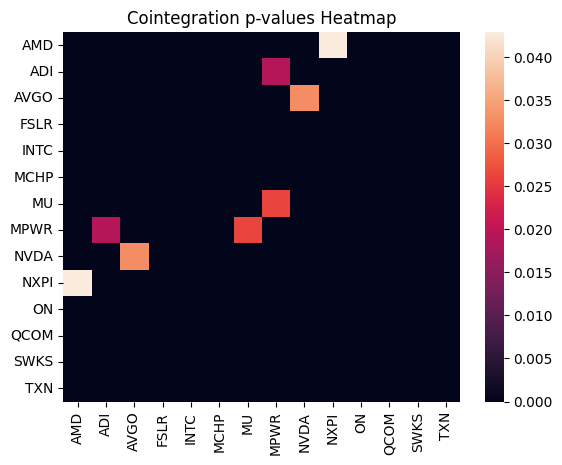

In [718]:
# Create a matrix of p-values
pvalues_matrix = np.zeros((len(tickers_list), len(tickers_list)))
for pair in sorted_pairs:
    i = tickers_list.index(pair[0])
    j = tickers_list.index(pair[1])
    pvalues_matrix[i, j] = pair[2]
    pvalues_matrix[j, i] = pair[2]  # Mirror the values

# Create heatmap
sns.heatmap(
    pvalues_matrix,
    xticklabels=tickers_list,
    yticklabels=tickers_list,
    mask=(pvalues_matrix > 0.10)
)
plt.title('Cointegration p-values Heatmap')
plt.show()

In [727]:
stock1 = df[f'{highest_p_val[0]}']
stock2 = df[f'{highest_p_val[1]}']

In [ ]:
results = sm.OLS(stock2, stock1).fit()
b = results.params[0]
spread = stock2 - b * stock1

/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/1819373247.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = results.params[0]


In [738]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   NXPI   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          5.289e+04
Date:                Fri, 20 Jun 2025   Prob (F-statistic):                        0.00
Time:                        21:44:14   Log-Likelihood:                         -6590.6
No. Observations:                1373   AIC:                                  1.318e+04
Df Residuals:                    1372   BIC:                                  1.319e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AMD            1.6652      0.007    229.981      0.000       1.651       1.679
==============================================================================
Omnibus:                      108.443   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.676
Skew:                          -0.677   Prob(JB):                     2.83e-31
Kurtosis:                       3.791   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [729]:
spread

Date
2020-01-02    36.102941
2020-01-03    35.798536
2020-01-06    35.322977
2020-01-07    37.059875
2020-01-08    38.052659
                ...    
2025-06-12    20.078380
2025-06-13    17.474852
2025-06-16     7.070263
2025-06-17     1.188003
2025-06-18     0.324195
Length: 1373, dtype: float64

In [730]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

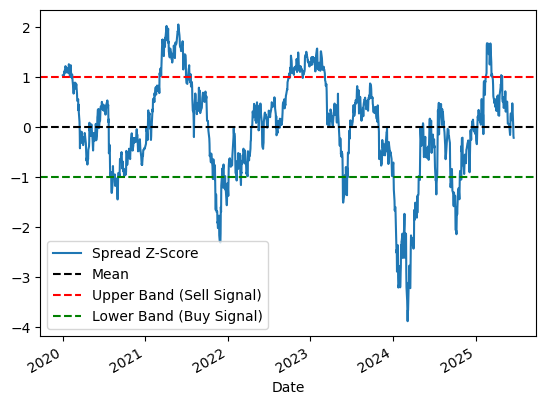

In [749]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread Z-Score', 'Mean', 'Upper Band (Sell Signal)', 'Lower Band (Buy Signal)'])

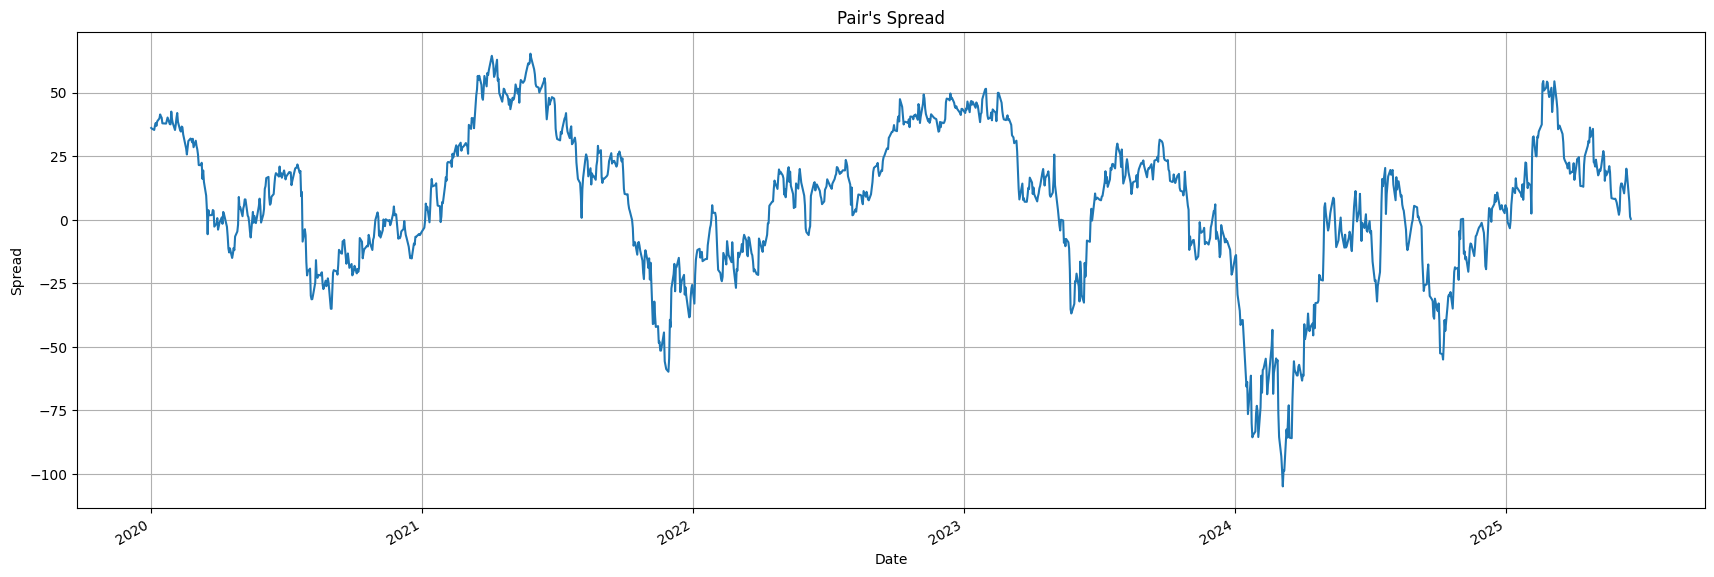

In [732]:
#plotting the spread
## May Not need this graphic, but keeping it for reference
plot = spread.plot(figsize=(21,7), title="Pair's Spread")
plot.set_ylabel('Spread')
plot.grid(True)

Text(0.5, 1.0, 'Crossing Price of AMD and NXPI')

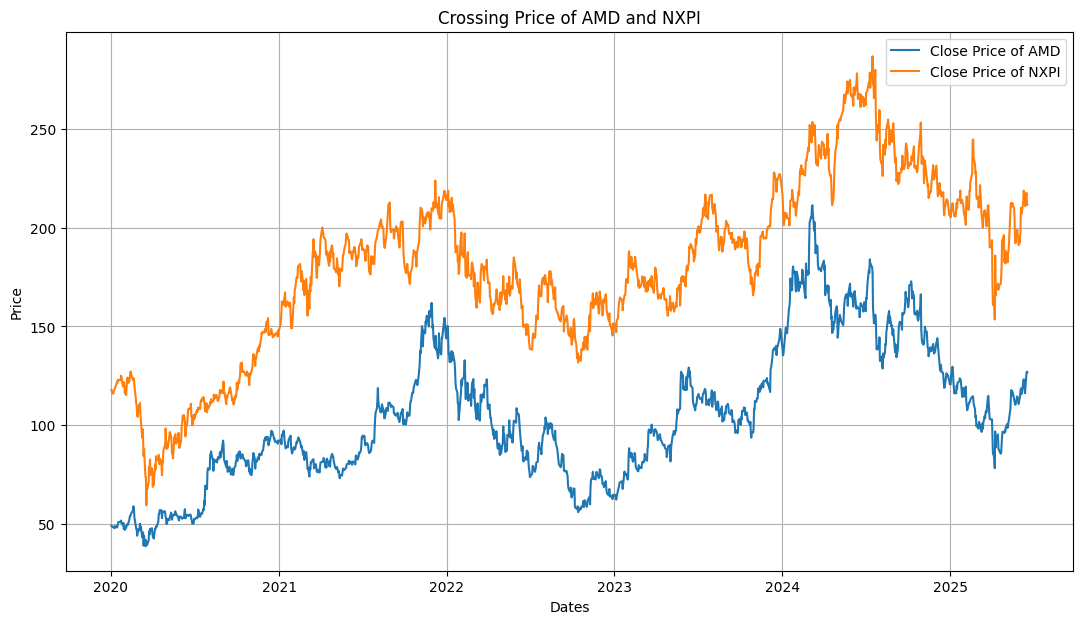

In [ ]:
plt.figure(figsize=(13, 7))
plt.plot(stock1, lw=1.5, label=f'Close Price of {highest_p_val[0]}')
plt.plot(stock2, lw=1.5, label=f'Close Price of {highest_p_val[1]}')
plt.grid(True)
plt.legend(loc=0)

plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title(f'Crossing Price of {highest_p_val[0]} and {highest_p_val[1]}')

<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date'>

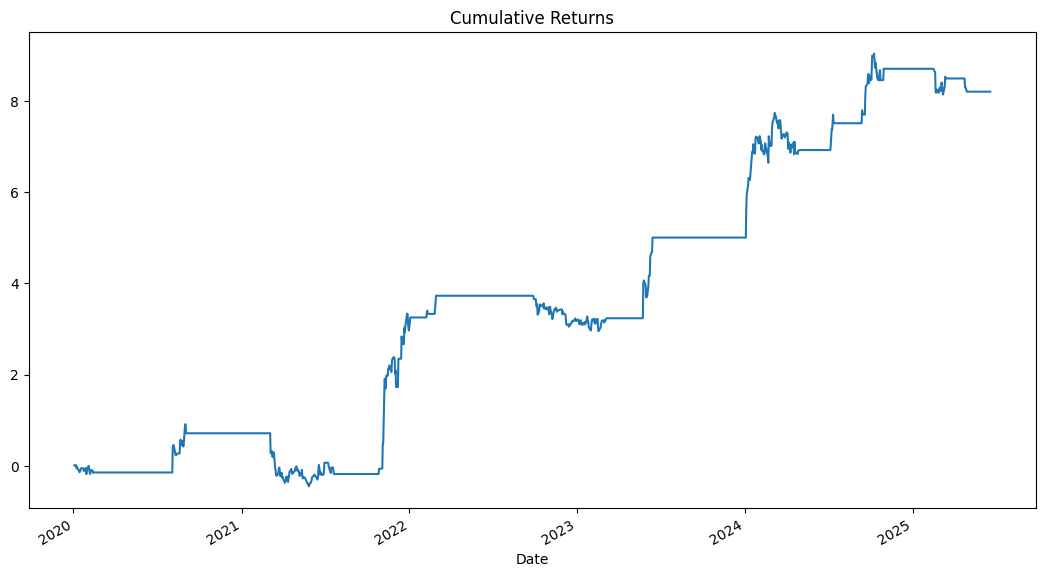

In [734]:
bt_df = pd.concat([zscore(spread), stock2 - b * stock1], axis=1)
bt_df.columns = ['signal', 'position']

bt_df['side'] = 0
bt_df.loc[bt_df['signal'] <= -1, 'side'] = 1
bt_df.loc[bt_df['signal'] >= 1, 'side'] = -1

returns = bt_df.position.pct_change() * bt_df.side
returns.cumsum().plot(figsize=(13,7), title="Cumulative Returns")

In [740]:
df[[f'{highest_p_val[0]}', f'{highest_p_val[1]}']]

Ticker,AMD,NXPI
Date,,
2020-01-02,49.099998,117.862358
2020-01-03,48.599998,116.725372
2020-01-06,48.389999,115.900131
2020-01-07,48.250000,117.403908
2020-01-08,47.830002,117.697327
...,...,...
2025-06-12,118.500000,217.399994
2025-06-13,116.160004,210.899994
2025-06-16,126.389999,217.529999


In [735]:
bt_df

,signal,position,side
Date,,,
2020-01-02,1.032166,36.102941,-1
2020-01-03,1.021551,35.798536,-1
2020-01-06,1.004969,35.322977,-1
2020-01-07,1.065534,37.059875,-1
2020-01-08,1.100152,38.052659,-1
...,...,...,...
2025-06-12,0.473394,20.078380,0
2025-06-13,0.382610,17.474852,0
2025-06-16,0.019805,7.070263,0


In [ ]:
# Neeed to add dependency for train_test_split
train_close, test_close = train_test_split(
    df[[f'{highest_p_val[0]}', f'{highest_p_val[1]}']],
    test_size=0.2,
    shuffle=False,
    random_state=0
)

In [746]:
model = sm.OLS(train_close[f'{highest_p_val[0]}'], train_close[f'{highest_p_val[1]}']).fit()
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.5828323628650487


/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/2740078049.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Hedge Ratio = ', model.params[0])


In [747]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    AMD   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          3.303e+04
Date:                Fri, 20 Jun 2025   Prob (F-statistic):                        0.00
Time:                        21:53:53   Log-Likelihood:                         -4751.4
No. Observations:                1098   AIC:                                      9505.
Df Residuals:                    1097   BIC:                                      9510.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NXPI           0.5828      0.003    181.735      0.000       0.577       0.589
==============================================================================
Omnibus:                      109.351   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.851
Skew:                           0.793   Prob(JB):                     2.13e-32
Kurtosis:                       3.819   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [748]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   NXPI   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          5.289e+04
Date:                Fri, 20 Jun 2025   Prob (F-statistic):                        0.00
Time:                        21:54:55   Log-Likelihood:                         -6590.6
No. Observations:                1373   AIC:                                  1.318e+04
Df Residuals:                    1372   BIC:                                  1.319e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AMD            1.6652      0.007    229.981      0.000       1.651       1.679
==============================================================================
Omnibus:                      108.443   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.676
Skew:                          -0.677   Prob(JB):                     2.83e-31
Kurtosis:                       3.791   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [578]:
df.columns = ['close', 'high', 'low', 'open', 'volume']

In [579]:
%%markdown 
## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



In [580]:
df['5MA_Returns'] = df['close'].rolling(window=5).mean().pct_change(periods=5)
df['15MA_Returns'] = df['close'].rolling(window=15).mean().pct_change(periods=15)
df['50MA_Returns'] = df['close'].rolling(window=50).mean().pct_change(periods=50)
df['5Volatility'] = df['close'].rolling(window=5).std()
df['next_close'] = df['close'].shift(-1)
df['returns'] = df['close'].pct_change()
df.dropna(inplace=True)

In [581]:
df_corr = df[df.columns].corr()
df_corr

,close,high,low,open,volume,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,next_close,returns
close,1.000000,0.999581,0.999670,0.999141,-0.320496,0.041228,0.030575,0.057106,0.777635,0.998667,0.020591
high,0.999581,1.000000,0.999523,0.999689,-0.314509,0.037414,0.029414,0.057557,0.781375,0.998406,0.006226
low,0.999670,0.999523,1.000000,0.999563,-0.325225,0.043498,0.032394,0.057949,0.771681,0.998426,0.009358
open,0.999141,0.999689,0.999563,1.000000,-0.318939,0.039558,0.030964,0.058427,0.776705,0.998035,-0.003874
volume,-0.320496,-0.314509,-0.325225,-0.318939,1.000000,0.017606,0.058931,0.029818,-0.084842,-0.318714,0.058308
5MA_Returns,0.041228,0.037414,0.043498,0.039558,0.017606,1.000000,0.308332,0.096785,-0.035792,0.040490,0.097253
15MA_Returns,0.030575,0.029414,0.032394,0.030964,0.058931,0.308332,1.000000,0.292896,-0.034283,0.030684,0.020924
50MA_Returns,0.057106,0.057557,0.057949,0.058427,0.029818,0.096785,0.292896,1.000000,-0.004295,0.057260,0.024348
5Volatility,0.777635,0.781375,0.771681,0.776705,-0.084842,-0.035792,-0.034283,-0.004295,1.000000,0.777722,0.007469
next_close,0.998667,0.998406,0.998426,0.998035,-0.318714,0.040490,0.030684,0.057260,0.777722,1.000000,0.017541


In [582]:
def find_highest_correlation_pair(df):
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_series = upper_triangle.stack()
    max_corr_index = corr_series.abs().idxmax()
    return max_corr_index, corr_series[max_corr_index]

highest_corr_pair, highest_corr_value = find_highest_correlation_pair(df[df_corr.columns])
print(f'Highest correlation pair: {highest_corr_pair} with correlation value: {highest_corr_value:.2f}')

Highest correlation pair: ('high', 'open') with correlation value: 1.00


In [566]:
x_train, x_test, y_train, y_test = train_test_split(
    df[df.columns[:-1]],  
    df['next_close'], 
    test_size=0.2, 
    shuffle=False
    )

In [567]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [568]:
abs_mae_lr = mean_absolute_error(y_test, y_pred)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f'Linear Regression Mean Absolute Error: {abs_mae_lr:.2f}')
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression R^2: {r2_lr:.2f}')

Linear Regression Mean Absolute Error: 3.45
Linear Regression RMSE: 4.61
Linear Regression R^2: 0.87


In [569]:
# Checking for overfitting
act_val = lr.score(x_train, y_train)
pred_val = lr.score(x_test, y_test)
print(f'r2 score for training set: {act_val:.2f}')
print(f'r2 score for test set: {pred_val:.2f}')

r2 score for training set: 1.00
r2 score for test set: 0.87


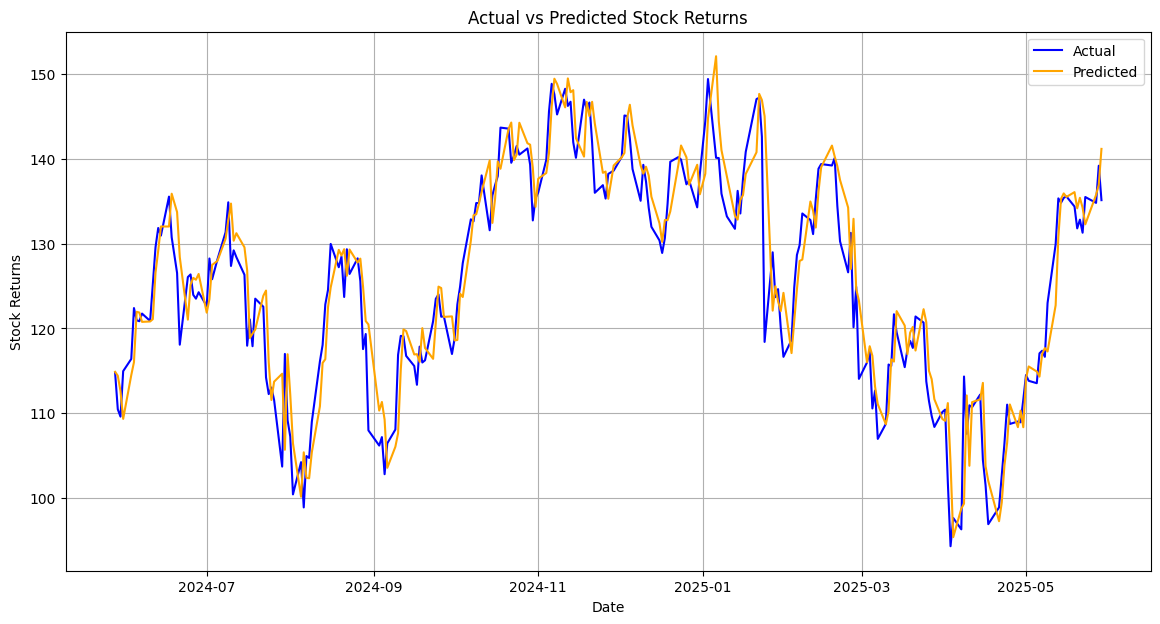

In [570]:
plt.figure(figsize=(14, 7))
plt.plot(x_test.index, y_test, label='Actual', color='blue')
plt.plot(x_test.index, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Returns')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.legend()
plt.grid()

Text(0, 0.5, 'Predicted Values')

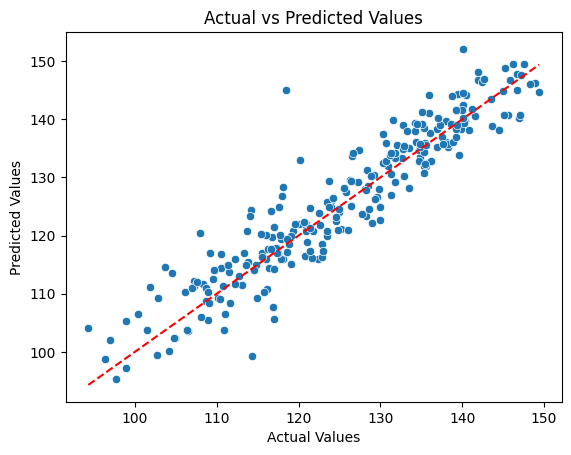

In [571]:
act_val = lr.score(x_train, y_train)
predict_val = lr.score(x_test, y_test)
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x = np.linspace(y_test.min(), y_test.max(), 100), 
             y = np.linspace(y_test.min(), y_test.max(), 100), 
             color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Residuals')

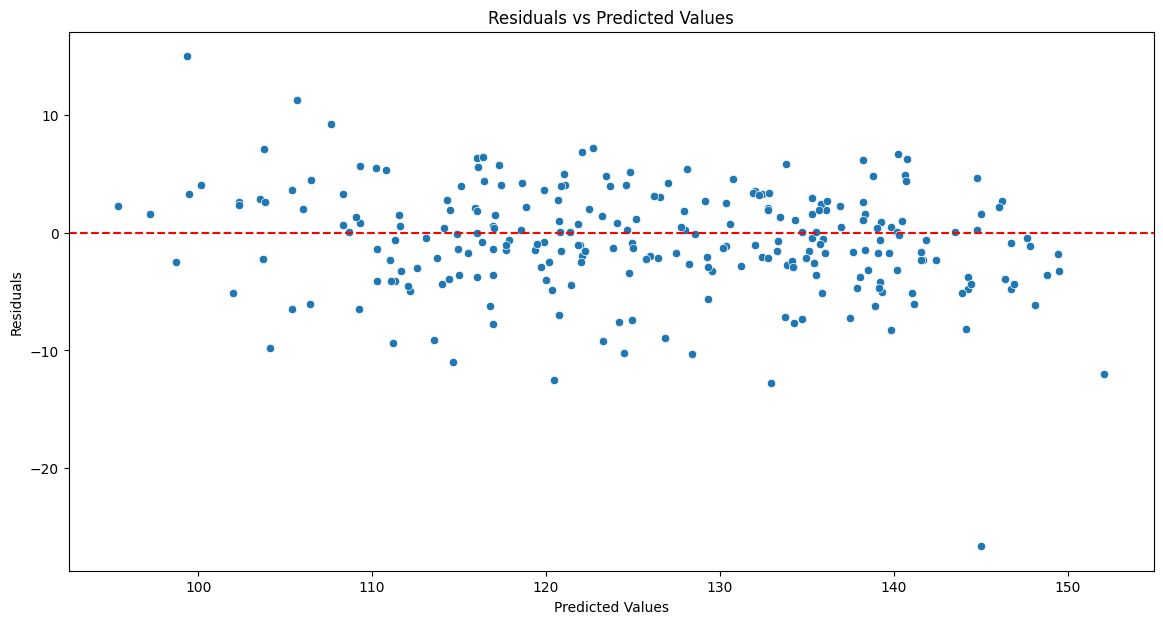

In [572]:
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

<Figure size 1400x700 with 0 Axes>

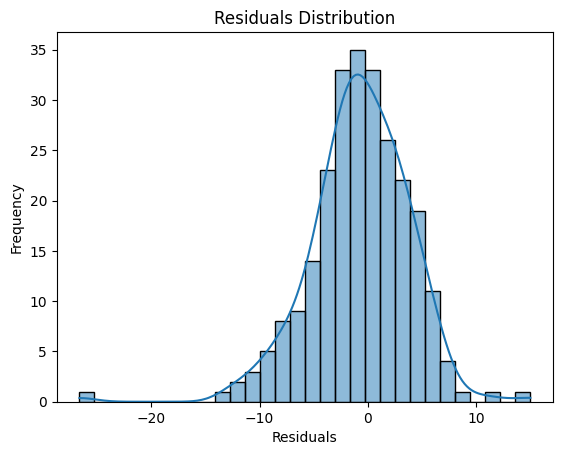

<Figure size 1400x700 with 0 Axes>

In [573]:
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.figure(figsize=(14, 7))


Text(0, 0.5, 'Sample Quantiles')

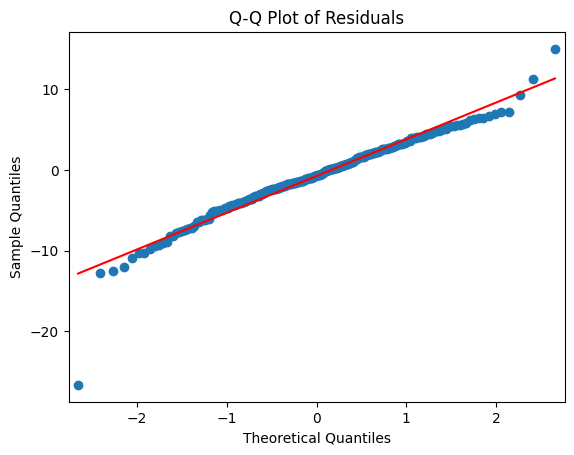

In [574]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [575]:
OLS_model = OLS(y_train, sm.add_constant(x_train)).fit()
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:             next_close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.446e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        21:36:46   Log-Likelihood:                -1589.8
No. Observations:                1008   AIC:                             3200.
Df Residuals:                     998   BIC:                             3249.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0228      0.129     -0.177   

In [583]:
df_new = df[['close', 'returns']]
df_new 

,close,returns
Date,,
2020-05-26,8.685748,-0.034178
2020-05-27,8.493956,-0.022081
2020-05-28,8.455845,-0.004487
2020-05-29,8.842921,0.045776
2020-06-01,8.773925,-0.007802
...,...,...
2025-05-22,132.830002,0.007815
2025-05-23,131.289993,-0.011594
2025-05-27,135.500000,0.032066


In [ ]:
adfuller_result = adfuller(df_new['returns'])

ADF Statistic: -21.75
p-value: 0.0000
The time series is stationary.
ACF Values: [ 1.         -0.05153905  0.0157884  -0.05469285 -0.02059184  0.01192793
  0.04198636  0.01810121  0.00676852  0.03877716 -0.04241648  0.03266341
  0.00772333  0.00395248 -0.05644609 -0.01526826  0.01759118 -0.05302091
  0.03037229  0.00522825  0.04746011]
PACF Values: [ 1.00000000e+00 -5.15799874e-02  1.31880954e-02 -5.34898222e-02
 -2.64843579e-02  1.10697481e-02  4.12736552e-02  1.97860474e-02
  8.49132150e-03  4.48019696e-02 -3.50916876e-02  2.87901929e-02
  1.46692358e-02  2.31696149e-04 -5.85061980e-02 -2.19263556e-02
  1.92112079e-02 -6.08510433e-02  1.71956029e-02  1.43031647e-02
  4.54906148e-02]


In [511]:
#TODO 7: Create buy and sell signals based on predictions

In [488]:
#TODO 8: Visualize the buy and sell signals on the stock price chart

In [489]:
#TODO 9: Evaluate the model's performance using Sharpe Ratio, total return vs buy and hold strategy.

In [490]:
#TODO 10: Using the buy and sell signals to send orders to the broker